### Fundamental Analysis of LNG Market
#### Pt 1: US LNG Exports

In [122]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Replace with your free EIA API Key
EIA_API_KEY = "elSaNABKZYzfuvpZpWefTS02WrsmH0tQUQ4v3CRr"

def get_eia_data(series_id):
    url = f"https://api.eia.gov/v2/seriesid/{series_id}?api_key={EIA_API_KEY}"
    r = requests.get(url)
    json_data = r.json()
    df = pd.DataFrame(json_data['response']['data'])
    df['period'] = pd.to_datetime(df['period'])
    df.set_index('period', inplace=True)
    return df

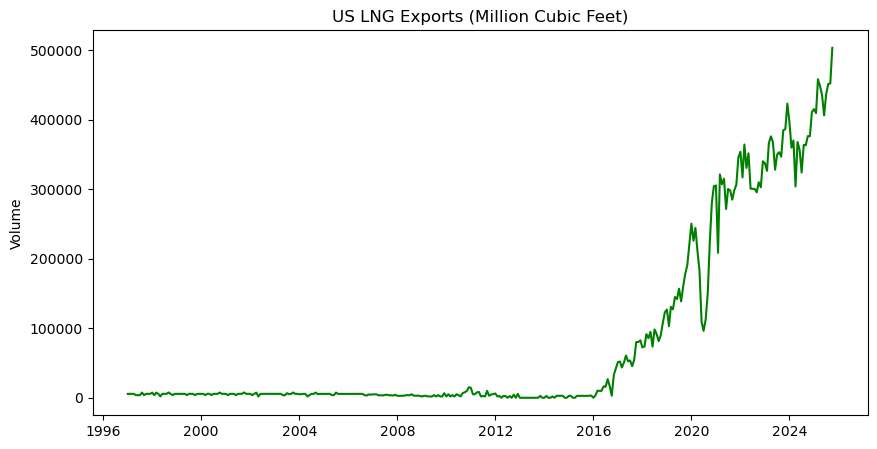

In [123]:
# Series ID for US Liquefied Natural Gas Exports
# Note: You can find IDs in the EIA Open Data browser
lng_exports = get_eia_data('NG.N9133US2.M') 

plt.figure(figsize=(10, 5))
plt.plot(lng_exports.index, lng_exports['value'], color='green')
plt.title('US LNG Exports (Million Cubic Feet)')
plt.ylabel('Volume')
plt.show()

#### Pt 2: Storage Analysis

In [124]:
# High-level logic for Storage Analysis
# 'Fullness' % is the key fundamental driver for winter pricing
storage_data = {
    'Date': ['2024-01-01', '2024-02-01', '2024-03-01'],
    'UK_Inventory': [85.5, 70.2, 55.8], # Percentage full
    'EU_Inventory': [88.1, 75.4, 62.1]
}
df_storage = pd.DataFrame(storage_data)

# Calculate the "Drawdown Rate"
df_storage['UK_Drawdown'] = df_storage['UK_Inventory'].diff()
print(df_storage)

         Date  UK_Inventory  EU_Inventory  UK_Drawdown
0  2024-01-01          85.5          88.1          NaN
1  2024-02-01          70.2          75.4        -15.3
2  2024-03-01          55.8          62.1        -14.4


#### Pt 3: Supply / Demand factors for LNG

In [126]:
# To track the global market, we'll focus on these three critical benchmarks:

# Asia (LNG) — PNGASJPUSDM: The primary benchmark for the Asian market, representing the price of seaborne LNG imports in Japan.
# Europe (Gas) — PNGASEUUSDM: The price of natural gas in the EU, reflecting the balance between regional pipeline supply and global LNG arrivals.
# US (Henry Hub) — MHHNGSP: The main US price benchmark (Louisiana hub) that serves as the cost basis for most American gas exports.

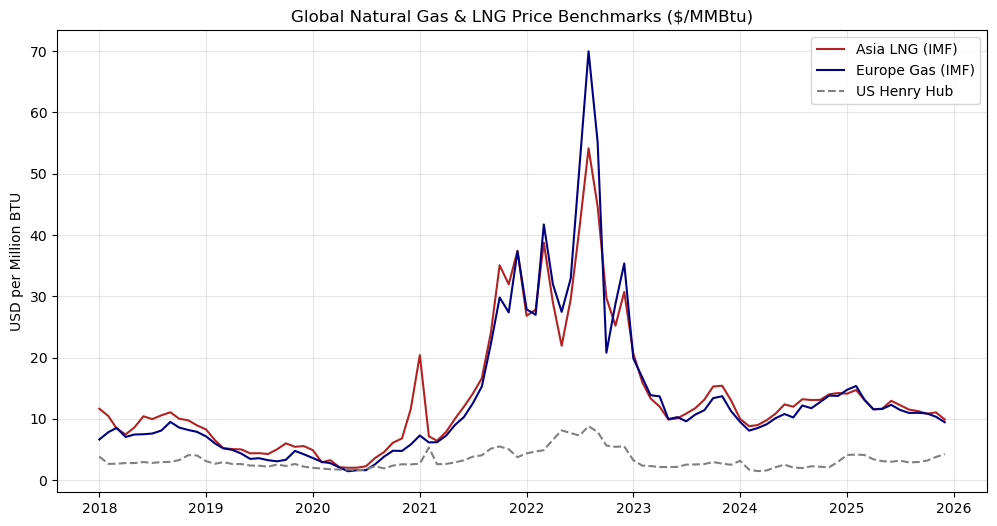

In [127]:
!pip install fredapi
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Initialize with your API key
fred = Fred(api_key='0b806931b6bd6e0374cc12897efe5426')

# Pulling the data
# We'll fetch from 2018 to capture the pre-pandemic, pandemic, and energy crisis era
data_ids = {
    'LNG_Asia': 'PNGASJPUSDM',
    'Gas_Europe': 'PNGASEUUSDM',
    'Henry_Hub_US': 'MHHNGSP'
}

df_list = []
for name, series_id in data_ids.items():
    s = fred.get_series(series_id, observation_start='2018-01-01')
    df_list.append(pd.DataFrame(s, columns=[name]))

# Combine into one DataFrame
lng_data = pd.concat(df_list, axis=1).dropna()

# Visualise the price convergence/divergence
plt.figure(figsize=(12, 6))
plt.plot(lng_data.index, lng_data['LNG_Asia'], label='Asia LNG (IMF)', color='firebrick')
plt.plot(lng_data.index, lng_data['Gas_Europe'], label='Europe Gas (IMF)', color='navy')
plt.plot(lng_data.index, lng_data['Henry_Hub_US'], label='US Henry Hub', color='gray', linestyle='--')

plt.title('Global Natural Gas & LNG Price Benchmarks ($/MMBtu)')
plt.ylabel('USD per Million BTU')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [128]:
# Create moving averages for European prices as an example
lng_data['EU_3MA'] = lng_data['Gas_Europe'].rolling(window=3).mean()
lng_data['EU_12MA'] = lng_data['Gas_Europe'].rolling(window=12).mean()

# Preview the first few rows 
print(lng_data[['Gas_Europe', 'EU_12MA']].tail())

            Gas_Europe    EU_12MA
2025-08-01   10.975232  12.775627
2025-09-01   11.003000  12.713309
2025-10-01   10.897000  12.558476
2025-11-01   10.355000  12.270476
2025-12-01    9.460000  11.912392


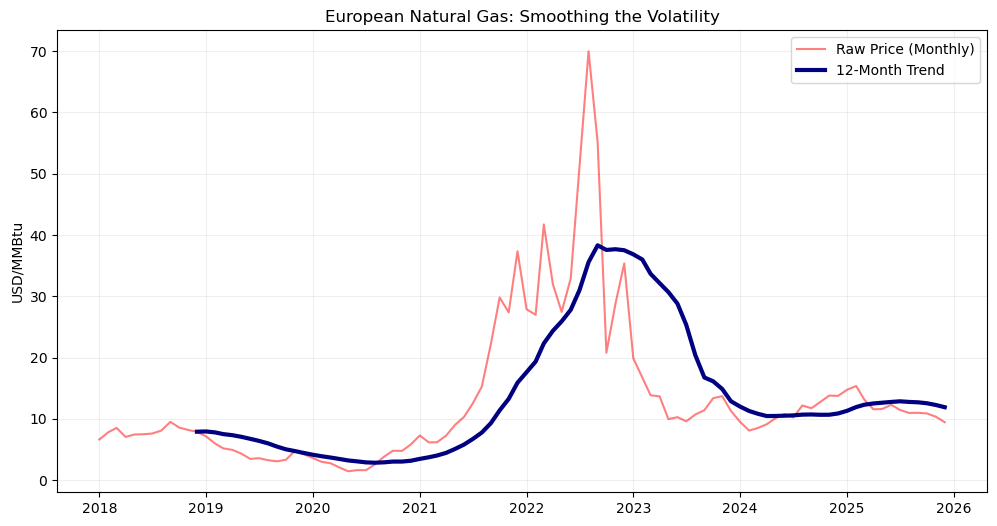

In [129]:
# 1. Calculate (Only needs to happen once)
lng_data['EU_12MA'] = lng_data['Gas_Europe'].rolling(window=12).mean()

# 2. Setup the single figure
plt.figure(figsize=(12, 6))

# 3. Layer the data
# Plot raw price
plt.plot(lng_data.index, lng_data['Gas_Europe'], 
         label='Raw Price (Monthly)', color='red', alpha=0.5)

# Plot the 12-month Moving Average
plt.plot(lng_data.index, lng_data['EU_12MA'], 
         label='12-Month Trend', color='navy', linewidth=3)

# 4. Final Touches
plt.title('European Natural Gas: Smoothing the Volatility')
plt.ylabel('USD/MMBtu')
plt.legend()
plt.grid(True, alpha=0.2)

# Use plt.show() OR a semicolon at the end of the last line to prevent double-printing
plt.show()

In [130]:
# 1. Calculate missing 3-month Moving Average
lng_data['EU_3MA'] = lng_data['Gas_Europe'].rolling(window=3).mean()

# 2. Re-calculate the 12-month just in case
lng_data['EU_12MA'] = lng_data['Gas_Europe'].rolling(window=12).mean()

# 3. Run signal logic
lng_data['Signal'] = 0 
lng_data.loc[lng_data['EU_3MA'] > lng_data['EU_12MA'], 'Signal'] = 1
lng_data.loc[lng_data['EU_3MA'] < lng_data['EU_12MA'], 'Signal'] = -1

# 4. Identify the 'Crossover' points
lng_data['Trade_Action'] = lng_data['Signal'].diff()

print(lng_data[['Gas_Europe', 'EU_3MA', 'EU_12MA', 'Signal']].tail())

            Gas_Europe     EU_3MA    EU_12MA  Signal
2025-08-01   10.975232  11.582155  12.775627      -1
2025-09-01   11.003000  11.149626  12.713309      -1
2025-10-01   10.897000  10.958411  12.558476      -1
2025-11-01   10.355000  10.751667  12.270476      -1
2025-12-01    9.460000  10.237333  11.912392      -1


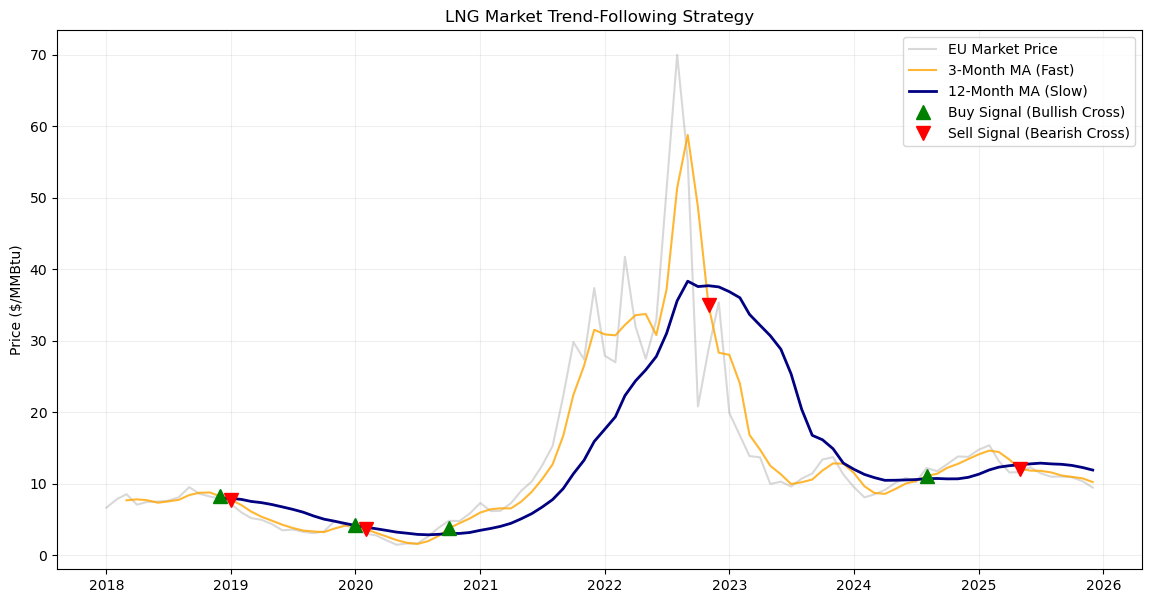

In [131]:
plt.figure(figsize=(14, 7))

# Plot prices and MAs
plt.plot(lng_data.index, lng_data['Gas_Europe'], label='EU Market Price', color='gray', alpha=0.3)
plt.plot(lng_data.index, lng_data['EU_3MA'], label='3-Month MA (Fast)', color='orange', alpha=0.8)
plt.plot(lng_data.index, lng_data['EU_12MA'], label='12-Month MA (Slow)', color='navy', linewidth=2)

# Plot Buy signals
plt.plot(lng_data[lng_data['Trade_Action'] > 0].index, 
         lng_data['EU_3MA'][lng_data['Trade_Action'] > 0], 
         '^', markersize=10, color='g', label='Buy Signal (Bullish Cross)')

# Plot Sell signals
plt.plot(lng_data[lng_data['Trade_Action'] < 0].index, 
         lng_data['EU_3MA'][lng_data['Trade_Action'] < 0], 
         'v', markersize=10, color='r', label='Sell Signal (Bearish Cross)')

plt.title('LNG Market Trend-Following Strategy')
plt.ylabel('Price ($/MMBtu)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [132]:
# 1. Calculate Market Returns (Buy and Hold)
# Represents your profit if you just bought gas on day one and held it
lng_data['Market_Return'] = lng_data['Gas_Europe'].pct_change()

# 2. Calculate Strategy Returns
# We use .shift(1) because we can only know to buy TODAY based on YESTERDAY'S signal
lng_data['Strategy_Return'] = lng_data['Market_Return'] * lng_data['Signal'].shift(1)

# 3. Calculate Cumulative Wealth (Starting with $100,000)
# We use .cumprod() to simulate compounding returns
lng_data['Buy_Hold_Wealth'] = 100000 * (1 + lng_data['Market_Return']).cumprod()
lng_data['Strategy_Wealth'] = 100000 * (1 + lng_data['Strategy_Return']).cumprod()

# Fill the first row (NaN) with your starting capital
lng_data[['Buy_Hold_Wealth', 'Strategy_Wealth']] = lng_data[['Buy_Hold_Wealth', 'Strategy_Wealth']].ffill().fillna(100000)

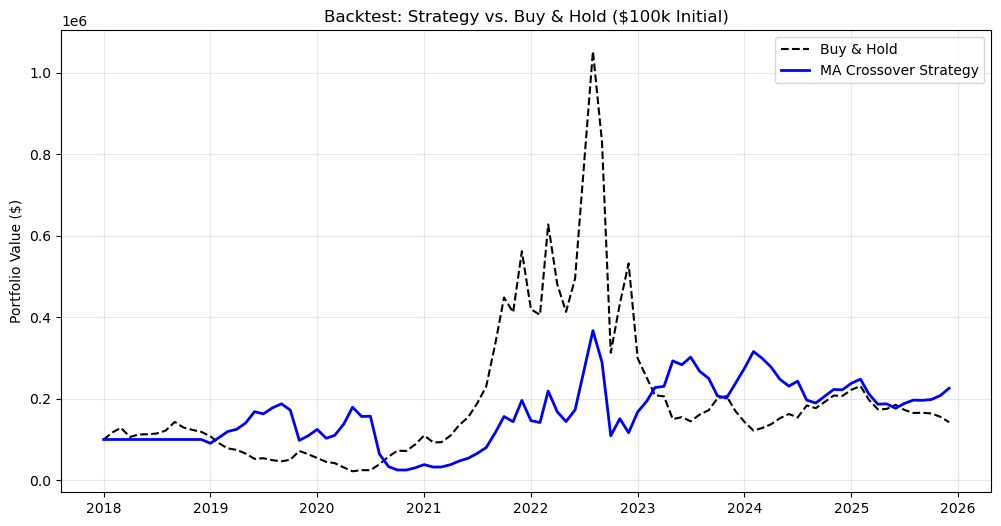

Final Buy & Hold Value: $142,291.94
Final Strategy Value:   $225,812.23


In [133]:
plt.figure(figsize=(12, 6))
plt.plot(lng_data.index, lng_data['Buy_Hold_Wealth'], label='Buy & Hold', color='black', linestyle='--')
plt.plot(lng_data.index, lng_data['Strategy_Wealth'], label='MA Crossover Strategy', color='blue', linewidth=2)

plt.title('Backtest: Strategy vs. Buy & Hold ($100k Initial)')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print Final Results
final_bh = lng_data['Buy_Hold_Wealth'].iloc[-1]
final_strat = lng_data['Strategy_Wealth'].iloc[-1]
print(f"Final Buy & Hold Value: ${final_bh:,.2f}")
print(f"Final Strategy Value:   ${final_strat:,.2f}")

#### Fundamental Analysis to do:
##### JKM–TTF spread
##### Norwegian Pipeline Integrity (Gassco Flows)
##### Cross-Commodity "Switching" (Spark Spreads)
##### Charter Rates
##### UK Wind Forecast

# LNG Physical Trade VaR Calculator (Parametric Approach)

This script calculates the Value at Risk (VaR) for a physical LNG cargo.

In [88]:
import numpy as np
from scipy.stats import norm

# Trade & Market Parameters
cargo_size_mmbtu = 3500000      # Standard cargo size (MMBtu)
current_price = 12.50           # USD/MMBtu (e.g., JKM Index)
volatility_ann = 0.40           # 40% annualized volatility
confidence_level = 0.95         # 95% confidence interval
holding_period_days = 5         # Time horizon (e.g., voyage/liquidation time)
trading_days_per_year = 252     # Standard trading days

# Calculations

# 1. Total Position Value
position_value = cargo_size_mmbtu * current_price

# 2. Scale Volatility to Holding Period
# Formula: Daily Vol * sqrt(Days)
sigma_hp = volatility_ann * np.sqrt(holding_period_days / trading_days_per_year)

# 3. Determine Z-Score
# For 95% confidence, z is approx 1.645
z_score = norm.ppf(confidence_level)

# 4. Calculate VaR
#the maximum loss you expect to see 95% of the time over 5 days
var_amount = position_value * sigma_hp * z_score 

# Results Output
print(f"LNG VaR ANALYSIS REPORT")
print("-" * 30)
print(f"Position Value: ${position_value:,.2f}")
print(f"Holding Period: {holding_period_days} days")
print(f"Confidence Level: {confidence_level:.0%}")
print(f"Expected Volatility: {sigma_hp:.2%}")
print("-" * 30)
print(f"VALUE AT RISK (VaR): ${var_amount:,.2f}")
print("-" * 30)
print(f"Interpretation: There is a {(1-confidence_level):.0%} chance that the ")
print(f"cargo will lose more than ${var_amount:,.2f} over the next {holding_period_days} days.")

LNG VaR ANALYSIS REPORT
------------------------------
Position Value: $43,750,000.00
Holding Period: 5 days
Confidence Level: 95%
Expected Volatility: 5.63%
------------------------------
VALUE AT RISK (VaR): $4,054,618.87
------------------------------
Interpretation: There is a 5% chance that the 
cargo will lose more than $4,054,618.87 over the next 5 days.


## Monte Carlo simulation

In [ ]:
import numpy as np

# Parameters
position_value = 43750000  # $43.75M
volatility_ann = 0.40
holding_period_days = 5
trading_days_per_year = 252
iterations = 10000         # Number of "what-if" scenarios

# 1. Calculate Periodic Volatility
# how much the price typically moves in a 5-day window so random numbers have range
sigma_hp = volatility_ann * np.sqrt(holding_period_days / trading_days_per_year)

# 2. Run the Simulation
# random seed ensures that each time code is run you get same random numbers. 
np.random.seed(42) # For consistent results
# We generate 10,000 random returns based on a normal distribution
# Using a 0% expected return ensuresconservative risk estimate
# not "banking" on profits which is what a <0% level would be
# Random Walk = Over short periods, price movememnts are noise, not steady trends. 
simulated_returns = np.random.normal(0, sigma_hp, iterations)

# 3. Calculate Simulated Gains/Losses
# We take those 10,000 random returns to our original total value
simulated_pnl = position_value * simulated_returns

# 4. Find the 95% VaR
# We take all 10,000 results and sort them from worst loss to biggest gain
# We then look at the 500th bottom/worst results
# Looking at 500th worst results is conservative approach, looking at worst cases so as to inform decisions
var_mc = np.percentile(simulated_pnl, 5)

# 95% of the time, our loss was better than this number
print(f"Monte Carlo VaR (95%): ${abs(var_mc):,.2f}")

Monte Carlo VaR (95%): $4,079,280.50


## TTF Futures model

1. Unconditional VaR: treats every 5-day period in the last two years as equally likely to happen, regardless of the season or current market events.

In [91]:
import pandas as pd
import numpy as np

# Use 'r' before the quotes to handle the Windows backslashes correctly
path = 'TTF NGF.csv'
df = pd.read_csv(path)

# Quick check to make sure it loaded
print("File loaded successfully!")
print(df.head()) # Shows the first 5 rows

File loaded successfully!
         Date   Price    Open    High     Low    Vol. Change %
0  24/06/2025  35.615  36.485  36.550  35.085   0.81K  -12.11%
1  06/03/2025  38.240  41.875  42.000  37.705   3.48K   -7.87%
2  13/02/2025  51.383  55.660  55.660  50.565  10.41K   -7.69%
3  04/04/2025  36.401  39.250  39.250  35.265   3.86K   -7.15%
4  09/04/2025  33.666  34.600  35.395  33.305  13.98K   -7.08%


In [96]:
import pandas as pd
import numpy as np

# 1. CONFIGURATION
path = 'TTF NGF.csv'
cargo_size_mmbtu = 3500000     
confidence_level = 95
holding_period = 5 

# 2. DATA LOAD & CLEANING
df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# 3. VALUATION
# Using most recent price from your Feb-26 contract
latest_price_mwh = df['Price'].iloc[-1]
latest_price_mmbtu = latest_price_mwh / 3.412
current_value = cargo_size_mmbtu * latest_price_mmbtu

# 4. HISTORICAL ANALYSIS
# Calculate rolling returns over 5-day window
df['5d_Return'] = df['Price'].pct_change(holding_period)
clean_returns = df['5d_Return'].dropna()

# VaR Calculation (95th Percentile)
var_pct = np.percentile(clean_returns, 100 - confidence_level)
var_dollar = abs(var_pct * current_value)

# Stress Test: The absolute worst 5-day drop in the 2-year history
worst_case_pct = clean_returns.min()
worst_case_dollar = abs(worst_case_pct * current_value)

# 5. THE DEAL REPORT
print("="*65)
print(f"NG DEAL VaR REPORT: TTF FEB-26 FUTURES (TFAc1)")
print("="*65)

print(f"\n[DEAL SUMMARY]")
print(f"Asset:              Dutch TTF Natural Gas Feb '26")
print(f"Exposure:           {cargo_size_mmbtu:,.0f} MMBtu")
print(f"Market Price:       €{latest_price_mwh:.2f}/MWh (${latest_price_mmbtu:.2f}/MMBtu)")
print(f"Est Val of Cargo:   ${current_value:,.2f} USD")

print(f"\n[RISK METRICS - {holding_period} DAY WINDOW]")
print(f"Confidence Level:   {confidence_level}%")

# Rolling Volatility = the intensity or speed of the price swings over a full year
print(f"Rolling Volatility: {clean_returns.std() * np.sqrt(252/holding_period):.2%} (Annualized)")
print(f"Value at Risk (VaR): ${var_dollar:,.2f}")
print(f"VaR as % of Cargo:  {abs(var_pct):.2%}")

print(f"\n[STRESS TEST]")
print(f"Worst 5-Day Move:   {worst_case_pct:.2%}")
print(f"Max Historical Loss: ${worst_case_dollar:,.2f}")

print("\n" + "="*65)
print(f"There is a 95% probability that losses will not exceed:")
print(f"${var_dollar:,.2f} over the next {holding_period} days.")
print(f"In a worst-case, losses on the deal could reach ${worst_case_dollar:,.2f}.")
print("="*65)

NG DEAL VaR REPORT: TTF FEB-26 FUTURES (TFAc1)

[DEAL SUMMARY]
Asset:              Dutch TTF Natural Gas Feb '26
Exposure:           3,500,000 MMBtu
Market Price:       €40.13/MWh ($11.76/MMBtu)
Est Val of Cargo:   $41,165,005.86 USD

[RISK METRICS - 5 DAY WINDOW]
Confidence Level:   95%
Rolling Volatility: 48.13% (Annualized)
Value at Risk (VaR): $3,791,131.45
VaR as % of Cargo:  9.21%

[STRESS TEST]
Worst 5-Day Move:   -19.16%
Max Historical Loss: $7,887,218.74

There is a 95% probability that losses will not exceed:
$3,791,131.45 over the next 5 days.
In a worst-case, losses on the deal could reach $7,887,218.74.


## Targeted Window Historical Simulation

In [103]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. CONFIGURATION:
path = 'TTF NGF.csv'
df = pd.read_csv(path)
position_value_usd = 43750000      # Reverted to exact deal value
confidence_level = 95
holding_period = 5 
ship_departure_date = "28/01/2026" # Today is 26th, ship leaves in 2 days
buffer_days = 30                  # Look at 15 days before/after Jan 28 in history

# 2. DATA LOAD & PREP
df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# 3. THE "MICRO-SEASON" FILTER
# This isolates late-Jan/early-Feb data from 2024 and 2025
target_dt = datetime.strptime(ship_departure_date, "%d/%m/%Y")

def is_in_target_window(date):
    # Match the calendar window regardless of the year
    start_window = target_dt.replace(year=date.year) - pd.Timedelta(days=buffer_days)
    end_window = target_dt.replace(year=date.year) + pd.Timedelta(days=buffer_days)
    return start_window <= date <= end_window

df_relevant = df[df['Date'].apply(is_in_target_window)].copy()

# 4. CALCULATION
# Calculate 5-day returns specifically within these seasonal pockets
df_relevant['5d_Return'] = df_relevant['Price'].pct_change(holding_period)
clean_returns = df_relevant['5d_Return'].dropna()

# VaR Calculation
var_pct = np.percentile(clean_returns, 100 - confidence_level)
var_amount = abs(var_pct * position_value_usd)
worst_case_pct = clean_returns.min()
stress_loss = abs(worst_case_pct * position_value_usd)

# 5. UPDATED DEAL REPORT
print(f"NG DEAL VaR REPORT: TARGETED DEPARTURE WINDOW")
print("="*65)

print(f"\n[DEAL SUMMARY]")
print(f"Risk Asset:         Dutch TTF Natural Gas Feb '26")
print(f"Ship Departure:     {ship_departure_date}")
print(f"Est Val of Cargo:   ${position_value_usd:,.2f} USD")

print(f"\n[RISK METRICS - {holding_period} DAY WINDOW]")
print(f"Confidence Level:   {confidence_level}%")
print(f"Relevant Samples:   {len(clean_returns)} days (Jan/Feb '24 & '25)")
print(f"Value at Risk (VaR): ${var_amount:,.2f}")
print(f"VaR as % of Cargo:  {abs(var_pct):.2%}")

print(f"\n[STRESS TEST]")
print(f"Worst 5-Day Move:   {worst_case_pct:.2%}")
print(f"Max Historical Loss: ${stress_loss:,.2f}")

print("\n" + "="*65)
print(f"SUMMARY: This model isolates 'late-January' market behavior.")
print(f"It predicts a 95% likelihood that losses won't exceed ${var_amount:,.2f}")
print(f"during the 5-day voyage starting January 28th.")


NG DEAL VaR REPORT: TARGETED DEPARTURE WINDOW

[DEAL SUMMARY]
Risk Asset:         Dutch TTF Natural Gas Feb '26
Ship Departure:     28/01/2026
Est Val of Cargo:   $43,750,000.00 USD

[RISK METRICS - 5 DAY WINDOW]
Confidence Level:   95%
Relevant Samples:   73 days (Jan/Feb '24 & '25)
Value at Risk (VaR): $14,383,819.38
VaR as % of Cargo:  32.88%

[STRESS TEST]
Worst 5-Day Move:   -41.88%
Max Historical Loss: $18,323,514.13

SUMMARY: This model isolates 'late-January' market behavior.
It predicts a 95% likelihood that losses won't exceed $14,383,819.38
during the 5-day voyage starting January 28th.
